# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.

import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse.csgraph import laplacian
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)
# Default silhouette_score does not support multivariate
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:

DATA_DIR = './data/00_data_1000_students/' # You many change the directory

# You can use the nrows=X argument in pd.read_csv to truncate your data
users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)

## Task 0: Research Question

**Research question:**
*Time series clustering per student to look at the difference between guided training and free training, with the goal of learning what type of learner each  student is.*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [3]:
# Your code for data processing goes here

# Number of weeks we look at for time series data 
WEEKS = 15 # TODO this needs to be fixed with a useful value (M2 of Tobias said roughly 15 weeks most users have in the big dataset)

# First we create the per week dataframes, then we create the features
weeks_a_year = 52 # Using 53 weeks to account for additional years would skew our data more than keeping it at 52 does.
years = pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().year
first_year = years.min()
events["week"] = pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().year-first_year
events["week"] = events["week"]*weeks_a_year+pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().week
start_weeks = pd.Series(events.groupby(by="user_id").min()["week"], name="start_weeks")
subtasks["week"] = pd.to_datetime(subtasks['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().year-first_year
subtasks["week"] = subtasks["week"]*weeks_a_year+pd.to_datetime(subtasks['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().week
# Now actually change it to each user starting with week 0
for user, start in start_weeks.items():
    events.loc[events["user_id"] == user, "week"] = events[events["user_id"] == user]["week"]-start
    subtasks.loc[subtasks["user_id"] == user, "week"] = subtasks[subtasks["user_id"] == user]["week"]-start

print(events.columns)
print(subtasks.columns)

/tmp/ipykernel_532036/607960902.py:12: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  start_weeks = pd.Series(events.groupby(by="user_id").min()["week"], name="start_weeks")


Index(['user_id', 'mode', 'game_name', 'learning_time_ms', 'number_range',
       'start', 'end', 'skill_id', 'type', 'week'],
      dtype='object')
Index(['event_id', 'user_id', 'aim', 'answer', 'answerMode',
       'availableNumbers', 'correct', 'correctAnswerObject', 'correctNumber',
       'destination', 'distance', 'hasProperResult', 'interval', 'lowerBound',
       'maxHeight', 'minHeight', 'mode', 'multiplier', 'number',
       'numberRepresentations', 'numberToMultiply', 'numbers', 'operandA',
       'operandB', 'operator', 'range', 'representation', 'representations',
       'result', 'solution', 'solutionRepresentation', 'solveMode', 'source',
       'speed', 'startPosition', 'subtask_finished_timestamp', 'target',
       'timeoutInSeconds', 'timeoutInSteps', 'type', 'upperBound', 'divisor',
       'orderIndependent', 'step', 'week'],
      dtype='object')


In [4]:
## Effort feature
# Total time learning per week
time_online = events.groupby(by=["user_id", "week"]).sum()["learning_time_ms"]
#print(time_online.head())
# TODO maybe total time online per week?

# Total interactions per week, here interactions we define as events and weeks
events_done = pd.Series(events.groupby(by=["user_id", "week"]).count()["skill_id"], name="events_done")
#sns.histplot(events_done)
#plt.show()

subtasks_done = pd.Series(subtasks.groupby(by=["user_id", "week"]).count()["event_id"], name="subtasks_done")
#sns.histplot(subtasks_done)
#plt.show()

effort = pd.DataFrame({
  "time_online": time_online,  
  "events_done": events_done,  
  "subtasks_done": subtasks_done,  
})
print(f"Count of users in effort: {len(events.groupby(by=['user_id']).sum().index)}")
effort.head()

/tmp/ipykernel_532036/3701322864.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_online = events.groupby(by=["user_id", "week"]).sum()["learning_time_ms"]


Count of users in effort: 926


/tmp/ipykernel_532036/3701322864.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(f"Count of users in effort: {len(events.groupby(by=['user_id']).sum().index)}")


time_online  events_done  subtasks_done
user_id week                                         
1       0          8835.0            1            2.0
        1         21167.0            1            1.0
        2         11182.0            1            1.0
        3          6823.0            1            1.0
        4          9107.0            1            1.0

In [5]:
# Helper functions
# FT as defined in 4.4 Frequency Based Measures of "How to quantify Student's regularity"
def fourier_transform(Xi, f, n):
    return np.dot(np.exp(-2j * np.pi * f * n), Xi)

In [6]:
## Regularity feature for both events and subtasks
# Heavy influence of code from https://github.com/epfl-ml4ed/flipped-classroom/blob/master/extractor/feature/reg_periodicity.py
subtasks["date"] = pd.to_datetime(subtasks['subtask_finished_timestamp'], infer_datetime_format=True)
events["date"] = pd.to_datetime(events['start'], infer_datetime_format=True)

# We have periodicity of week day
def period_of_week_day(users_events):
    # Convert date to days starting from 0
    days = users_events["date"].values.astype(np.int64) // 10 ** 9 // (24 * 3600)
    days -= min(days)
    period_length = WEEKS * 7
    activity = np.array([int(d in days) for d in range(period_length)])  # 1 if active at day d, 0 o.w.
    n = np.arange(period_length)
    return abs(fourier_transform(activity, 1 / 7, n))
event_week_day_periodicity = events.groupby(by=["user_id"]).apply(lambda users_events: period_of_week_day(users_events))
subtask_week_day_periodicity = subtasks.groupby(by=["user_id"]).apply(lambda users_tasks: period_of_week_day(users_tasks))

# We have periodicity of week hour
def period_of_week_hour(users_events):
    period_length = WEEKS * 7 * 24
    hours = users_events['date'].values.astype(np.int64) // 10 ** 9 // 3600
    hours -= min(hours)
    activity = np.array([int(t in hours) for t in range(period_length)])
    n = np.arange(period_length)
    return abs(fourier_transform(activity.flatten(), 1 / (7 * 24), n))
event_week_hour_periodicity = events.groupby(by=["user_id"]).apply(lambda users_events: period_of_week_hour(users_events))
subtask_week_hour_periodicity = subtasks.groupby(by=["user_id"]).apply(lambda users_tasks: period_of_week_hour(users_tasks))

# We have periodicity of day hour
def period_of_day_hour(users_events):
    # Convert date to hours starting from 0
    hours = users_events['date'].values.astype(np.int64) // 10 ** 9 // 3600
    hours -= min(hours)
    period_length = WEEKS * 7 * 24
    activity = np.array([int(t in hours) for t in range(period_length)])  # 1 if active at hour t 0 o.w.
    if np.sum(activity) == 0:
        print(f'Feature period_of_day_hour is invalid: the m1 mode is invalid')
        raise ValueError
    n = np.arange(period_length)
    return abs(fourier_transform(activity, 1 / 24, n))
event_day_hour_periodicity = events.groupby(by=["user_id"]).apply(lambda users_events: period_of_day_hour(users_events))
subtask_day_hour_periodicity = subtasks.groupby(by=["user_id"]).apply(lambda users_tasks: period_of_day_hour(users_tasks))


In [7]:
regularity = pd.DataFrame({
  "event_week_day_periodicity": event_week_day_periodicity,  
  "subtask_week_day_periodicity": subtask_week_day_periodicity,  
  "event_week_hour_periodicity": event_week_hour_periodicity,  
  "subtask_week_hour_periodicity": subtask_week_hour_periodicity,  
  "event_day_hour_periodicity": event_day_hour_periodicity,  
  "subtask_day_hour_periodicity": subtask_day_hour_periodicity,  
})
print(f"Count of users in regularity: {len(regularity.index)}")
regularity.describe()

Count of users in regularity: 926


,event_week_day_periodicity,subtask_week_day_periodicity,event_week_hour_periodicity,subtask_week_hour_periodicity,event_day_hour_periodicity,subtask_day_hour_periodicity
count,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000
mean,5.364138,4.438951,6.318084,5.223753,12.576300,10.064214
std,4.444956,4.450729,5.472554,5.513216,11.327325,11.425282
min,0.198062,0.198062,0.112141,0.112141,0.765367,0.765367
25%,1.965435,1.000000,2.057998,1.000000,3.773942,1.000000
50%,4.079385,2.757513,4.872920,3.029816,9.484410,5.869580
75%,7.371976,6.383855,8.842421,7.412581,18.106322,15.387476
max,26.359095,26.359095,34.803687,34.804643,71.878006,71.878006


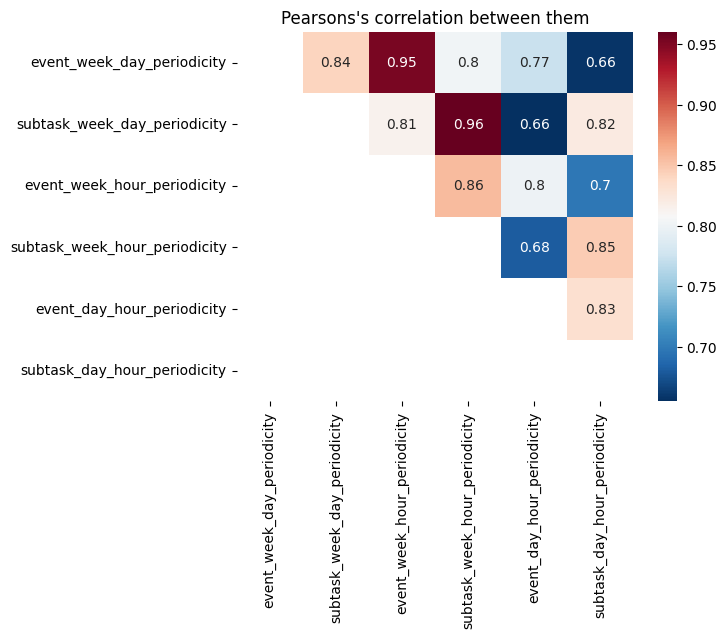

In [8]:
corr = np.round(regularity.corr(method='pearson'), 3)
mask = np.tril(corr)
ax = plt.axes()
heatmap = sns.heatmap(corr, annot=True, mask=mask, cmap='RdBu_r')
ax.set_title("Pearsons's correlation between them")
plt.show()
# Looking at the correlation matrix we see that the relevant ones are not completely correlated
# this means we should be able to get more information out from using both (events & subtasks)

## Task 2: Model Building

Train a model for your research question. 

In [22]:
# Combine all features and for now use the complete first 15 weeks (later also with 15 active weeks)
combined_features = effort[effort.index.get_level_values(1) <= WEEKS]

Simpler direct application of tslearn k-means to the raw set of our features.

In [49]:
reshaped_feature = pd.DataFrame(combined_features, copy=True).fillna(0)
print(f"Each element will be a list of {reshaped_feature.columns.values} features")
# Create a combined feater list and unstack it
reshaped_feature["combined"] = reshaped_feature.values.tolist()
reshaped_feature = reshaped_feature["combined"].unstack(level=1)
# Sort columns by week, as now it is a time series
reshaped_feature = reshaped_feature.reindex(sorted(reshaped_feature.columns), axis=1)
reshaped_feature

Each element will be a list of ['time_online' 'events_done' 'subtasks_done'] features


week,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,,,,,,,,,,,,,,,,
1,"[8835.0, 1.0, 2.0]","[21167.0, 1.0, 1.0]","[11182.0, 1.0, 1.0]","[6823.0, 1.0, 1.0]","[9107.0, 1.0, 1.0]","[10703.0, 1.0, 1.0]","[1383.0, 1.0, 2.0]",NaN,NaN,NaN,NaN,"[6052.0, 1.0, 1.0]","[6055.0, 1.0, 1.0]","[10541.0, 1.0, 1.0]","[22864.0, 2.0, 2.0]",NaN
2,"[4636.0, 1.0, 2.0]","[33195.0, 4.0, 7.0]",NaN,"[34141.0, 2.0, 2.0]","[28064.0, 4.0, 6.0]","[12129.0, 2.0, 2.0]","[366071.0, 5.0, 5.0]",NaN,"[28973.0, 2.0, 2.0]","[57922.0, 3.0, 3.0]","[60564.0, 4.0, 4.0]","[30292.0, 5.0, 5.0]","[13545.0, 3.0, 4.0]","[32508.0, 5.0, 5.0]","[7699.0, 2.0, 3.0]","[109946.0, 2.0, 2.0]"
3,"[7639.0, 2.0, 4.0]","[2932.0, 1.0, 2.0]",NaN,NaN,"[21150.0, 4.0, 5.0]",NaN,"[7066.0, 1.0, 1.0]","[1354.0, 1.0, 2.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[22898.0, 1.0, 1.0]"
4,"[12093.0, 1.0, 2.0]",NaN,NaN,"[180999.0, 1.0, 1.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"[10275.0, 1.0, 2.0]","[24634.0, 1.0, 1.0]","[20866.0, 1.0, 1.0]","[12177.0, 2.0, 2.0]",NaN,"[6086.0, 1.0, 1.0]",NaN,NaN,NaN,"[12174.0, 2.0, 2.0]",NaN,NaN,"[11570.0, 2.0, 3.0]","[1950.0, 1.0, 2.0]","[7228.0, 1.0, 1.0]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"[6037.0, 1.0, 0.0]","[177141.0, 1.0, 0.0]","[25283.0, 3.0, 0.0]","[15239.0, 2.0, 0.0]",NaN,NaN,NaN,"[23260.0, 1.0, 0.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,"[4303.0, 1.0, 2.0]","[10091.0, 3.0, 6.0]",NaN,NaN,NaN,"[2433.0, 1.0, 2.0]",NaN,NaN,NaN,"[118332.0, 1.0, 1.0]",NaN,NaN,NaN,NaN,NaN,NaN
997,"[17995.0, 2.0, 3.0]",NaN,NaN,NaN,"[12253.0, 1.0, 1.0]","[6783.0, 1.0, 1.0]",NaN,"[71926.0, 3.0, 9.0]","[18388.0, 3.0, 3.0]","[19079.0, 2.0, 2.0]",NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Fill missing values with NaN filler list --> impossible to do in a smarter way
nan_filler_list = np.array([0] * len(combined_features.columns))
arr = reshaped_feature.values
nan_mask = np.vectorize(lambda x: isinstance(x, float) and np.isnan(x))(arr)
for i in range(len(arr)):
    for j in range(len(arr[i])):
        if nan_mask[i][j]:
            arr[i][j] = nan_filler_list
        else:
            arr[i][j] = np.array(arr[i][j])
            
arr = np.array([np.stack(x) for x in arr])

In [53]:
# Multivariate time series clustering
print("DBA k-means for multivariate clustering")
silhouette_list = []
rang = range(2, 4)
for clusters in rang:
    print(f"Doing now with {clusters} clusters.")
    dba_km = TimeSeriesKMeans(n_clusters=clusters,
                          #n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=50,
                          random_state=69)
    y_pred = dba_km.fit_predict(arr)
    ss = silhouette_score(arr, y_pred)
    silhouette_list.append(ss)

sns.lineplot(x=rang, y=silhouette_list)
plt.show()


DBA k-means for multivariate clustering
Doing now with 2 clusters.


KeyboardInterrupt: 

In [ ]:
reshaped_feature = effort[effort.index.get_level_values(1) <= WEEKS]["time_online"][:6000]
# Now unstack the user_id and fill with 0 all nan
reshaped_feature = reshaped_feature.unstack(level=1).fillna(0)
print(f"reshaped_feature.shape: {reshaped_feature.shape}")

reshaped_feature.shape: (851, 16)


DBA k-means
Doing now with 2 clusters.
Doing now with 3 clusters.
Doing now with 4 clusters.
Doing now with 5 clusters.
Doing now with 6 clusters.
Doing now with 7 clusters.
Doing now with 8 clusters.
Doing now with 9 clusters.


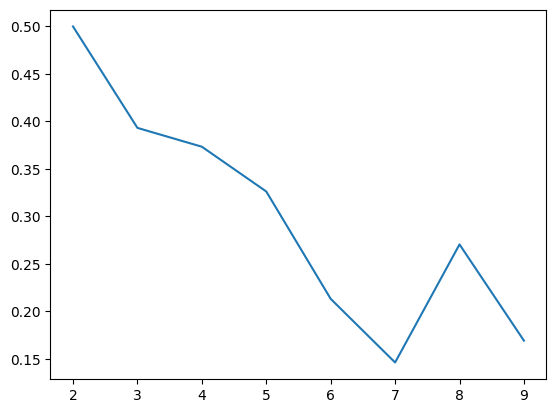

In [ ]:
# Univariate time series clustering
print("DBA k-means")
silhouette_list = []
rang = range(2, 10)
for clusters in rang:
    print(f"Doing now with {clusters} clusters.")
    dba_km = TimeSeriesKMeans(n_clusters=clusters,
                          #n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=50,
                          random_state=69)
    y_pred = dba_km.fit_predict(reshaped_feature)
    ss = silhouette_score(reshaped_feature, y_pred)
    silhouette_list.append(ss)

sns.lineplot(x=rang, y=silhouette_list)
plt.show()


Full pipeline of flippedClassroom paper; computational feasability not there yet.

In [ ]:
# Your code for training a model goes here

## Make similarity matrices for each feature at first (later try multivariate)

# For the regularity features we need to make a similarity matrix with euclidian distance
def eucl_similarity_func(u, v):
    # Would directly give the similarity using euclidian distance
    return 1/(1+euclidean(u,v))

def gaussian_kernel(distance_mat, sigma):
    return np.exp(-distance_mat ** 2 / 2.*sigma ** 2)

# Gives the distance matrix in vector form, i.e. upper triangular part of the distance matrix
reg_dists = pdist(regularity, metric='euclidean')
# Reshape and put into pd
reg_dists = pd.DataFrame(squareform(reg_dists), columns=regularity.index, index=regularity.index)
# Now apply the gaussian kernel to make a similarity matrix
sigma = 1 # TODO is a hyper parameter tuning needed
reg_dists = gaussian_kernel(reg_dists, sigma)
print(f"Shape of regularity distance matrix: {reg_dists.shape}")

# For the time series features we use DTW

Shape of regularity distance matrix: (926, 926)


In [ ]:
def dtw_distance_func(u, v):
    #dtw(u, v, dist="square", method="sakoechiba", window=10)
    resolution, radius = 5, 2
    dtw_multiscale = dtw(
        u, v, dist='square', method='multiscale',
        options={'resolution': resolution, 'radius': radius}, return_path=False
    )
    return dtw_multiscale

In [ ]:
# https://github.com/epfl-ml4ed/fc-clustering/blob/234f6c65dbc88869d2f9ffcf937df63381546f9a/src/features/preprocess.py#L5
def normalize(distance_matrix):
    # fix infinity
    distance_matrix[np.isinf(distance_matrix)] = 0

    # robust standarizatoin
    flat_nan = distance_matrix[~np.isnan(distance_matrix)]
    median = np.median(flat_nan)
    q1 = np.percentile(flat_nan, 10)
    q3 = np.percentile(flat_nan, 90)
    IQR = q3 - q1
    if IQR==0:
        IQR = 1
    S =  (distance_matrix - median) / IQR

    # then normalization
    range_matrix = np.max(S) - np.min(S)
    normalized = (S - np.min(S)) / range_matrix
    return normalized

In [ ]:
dimension_sim_matrx = {
    "regularity": reg_dists,
    "effort_time_online": None,
    "effort_events_done": None,
    "effort_subtasks_done": None,
}
for feature in effort.columns:
    # First get the relevant feature
    reshaped_feature = effort[effort.index.get_level_values(1) <= WEEKS][feature][:6000]
    # Now unstack the user_id and fill with 0 all nan
    # TODO the fillna does not make sense, what to do??
    # Probably we want to not use first x weeks, but rather x weeks of data points
    reshaped_feature = reshaped_feature.unstack(level=1).fillna(0)
    #print(reshaped_feature.head(3))
    # Now given this matrix, we can calculate the distance matrix
    dist_mat_feature = pdist(reshaped_feature, metric=dtw_distance_func)
    # Reshape and put into pd
    dist_mat_feature = pd.DataFrame(squareform(dist_mat_feature), columns=reshaped_feature.index, index=reshaped_feature.index)
    sigma = 1 # TODO is a hyper parameter tuning needed per feature
    # Last step is converting this into a similarity matrix using the gaussian kernel using silhoutte score
    dimension_sim_matrx[f"effort_{feature}"] = gaussian_kernel(dist_mat_feature, sigma)
    print(f"Done with {feature} distance matrix: {dimension_sim_matrx[f'effort_{feature}'].shape} shape")

Done with time_online distance matrix: (851, 851) shape
Done with events_done distance matrix: (851, 851) shape
Done with subtasks_done distance matrix: (851, 851) shape


In [ ]:
# Save the dimension similarity matrices to a pickle file
def save_sim_mat():
    with open('dimension_sim_matrx.pickle', 'wb') as handle:
        pickle.dump(dimension_sim_matrx, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_sim_mat():
    global dimension_sim_matrx
    with open('dimension_sim_matrx.pickle', 'rb') as handle:
        dimension_sim_matrx = pickle.load(handle)
load_sim_mat()

According to fitted curve, doing 70k students takes 89592.22 minutes


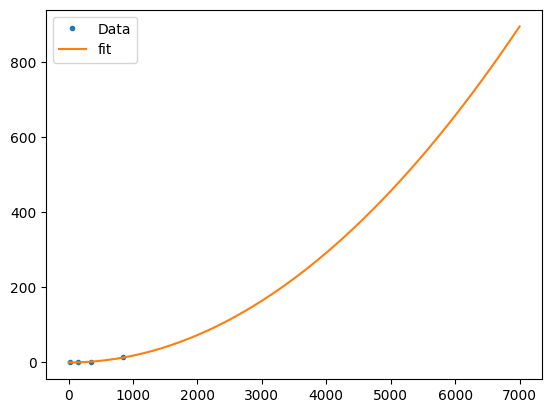

In [3]:
# Feasability check of growing curve for time used
import scipy
import numpy as np
import matplotlib.pyplot as plt

xdata = np.array([16, 142, 344, 851])
ydata = np.array([0.01, 0.5, 1.15, 13.1]) # minutes
# Plot the actual data
plt.plot(xdata, ydata, ".", label="Data")

# The actual curve fitting happens here
# Number of comparisions has computational order of O(n**2)
ex = lambda t,a,b: a+b*t**2
optimizedParameters, pcov = scipy.optimize.curve_fit(ex, xdata, ydata) 

# Use the optimized parameters to plot the best fit
plot_x = np.linspace(0, 7000)
plt.plot(plot_x, ex(plot_x, *optimizedParameters), label="fit")

print(f"According to fitted curve, doing 70k students takes {ex(70000, *optimizedParameters):.2f} minutes")

# Show the graph
plt.legend()
plt.show()

In [ ]:
# Spectral clustering

SEED = 111
affinity = np.sum([
    dimension_sim_matrx["effort_subtasks_done"],
    dimension_sim_matrx["effort_events_done"],
    #dimension_sim_matrx["effort_time_online"], # For now time_online is probably wrong bc of the fillna
    dimension_sim_matrx["regularity"]], axis=0)
print(f"Shape of affinity matrix: {affinity.shape}")

# Code from https://github.com/epfl-ml4ed/fc-clustering/blob/234f6c65dbc88869d2f9ffcf937df63381546f9a/src/models/clustering.py
def spectral_clustering(affinity,  n_clusters=3, random_state=SEED):
    """
    Spectral clustering
    :param affinity: np array of data points or affinity matrix
    :param n_clusters: number of clusters
    :return: tuple (kmeans, maps, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        maps is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues
    """
    # Compute eigengap heuristic
    L = laplacian(affinity, normed=True)
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    maps = spectral_embedding(affinity, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(maps)

    return kmeans, maps, eigenvals_sorted

Shape of affinity matrix: (926, 926)


## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of proj_X: (926, 2) and y_pred: (926,)


/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of proj_X: (926, 3) and y_pred: (926,)


/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of proj_X: (926, 4) and y_pred: (926,)


/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of proj_X: (926, 5) and y_pred: (926,)


/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of proj_X: (926, 6) and y_pred: (926,)


/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of proj_X: (926, 7) and y_pred: (926,)


/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of proj_X: (926, 8) and y_pred: (926,)


/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of proj_X: (926, 9) and y_pred: (926,)


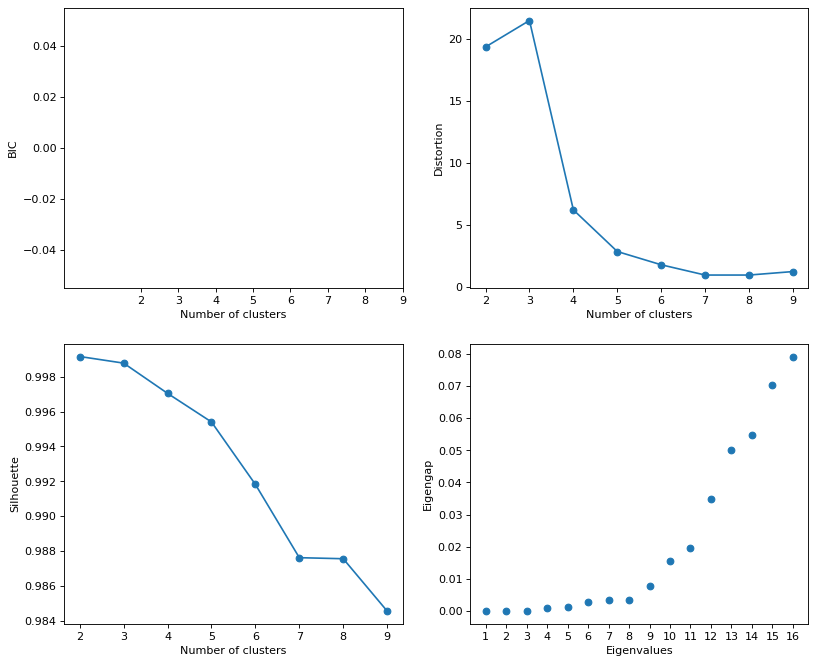

In [ ]:
# Your code for model evaluation goes here

# Again code from FC clustering
def compute_bic(kmeans, X):
    """
    Computes the BIC metric
    :param kmeans: clustering object from scikit learn
    :param X: np array of data points
    :return: BIC
    """
    # Adapted from: https://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans
    # assign centers and labels
    BIC = -1
    try:
        centers = [kmeans.cluster_centers_]
        labels  = kmeans.labels_
        #number of clusters
        m = kmeans.n_clusters
        # size of the clusters
        n = np.bincount(labels)
        #size of data set
        N, d = X.shape

        #compute variance for all clusters beforehand
        cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]],
                 'euclidean')**2) for i in range(m)])

        const_term = 0.5 * m * np.log(N) * (d+1)

        LL = np.sum([n[i] * np.log(n[i]) -
                   n[i] * np.log(N) -
                 ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
                 ((n[i] - 1) * d/ 2) for i in range(m)])

        BIC = LL - const_term
    except  Exception as e:
        print(e)
        print("error")
        pass

    return 

def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]
    :param n_clusters_list: List of number of clusters to explore
    :param metric_dictionary:
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(2, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1
    return fig

def get_heuristics_spectral(X, n_clusters_list=range(2, 10)):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering
    :param X: np array of data points
    :param n_clusters_list: List of number of clusters to explore
    """
    silhouette_list = []
    distortion_list = []
    bic_list = []
    eigengap_list = []

    for n in n_clusters_list:
        kmeans, proj_X, eigenvals_sorted = spectral_clustering(X, n)
        y_pred = kmeans.labels_

        if n == 1:
            silhouette = np.nan
        else:
            print(f"Shape of proj_X: {proj_X.shape} and y_pred: {y_pred.shape}")
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)

        distortion = kmeans.inertia_
        distortion_list.append(distortion)

        bic = compute_bic(kmeans, proj_X)
        bic_list.append(bic)

    metric_dictionary = {'BIC': bic_list,
                         'Distortion': distortion_list,
                         'Silhouette': silhouette_list,
                         #https://ai.stackexchange.com/questions/35262/how-can-i-select-k-value-of-k-means-from-eigengap
                         'Eigengap': eigenvals_sorted}

    plot_metrics(n_clusters_list, metric_dictionary)

get_heuristics_spectral(affinity)

*Your discussion/interpretation about your model's behavior goes here*

This model is not feasable for any sensible size of subset of our dataset because it just takes too long to run.
Even if we could run it on a biger subset of our data, the small subset seems to suggest that no clusters work really well (we do not have a peak in the Silhouette score), as a K of two or three is both not really interpretable.